# Análise de dados da base Titanic

Pré requisitos para importar o dataset do Kaggle:

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Download do dataset:

In [ ]:
! kaggle competitions download titanic

In [ ]:
! unzip titanic

# Bibliotecas utilizadas:

In [ ]:
! pip install --pre pycaret

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pycaret.classification import *

# Funções:

In [ ]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(12,9))
    plt.xticks(rotation=90)
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

# Análise:

Vamos analisar no geral o que possuimos nas tabelas de dados:

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_gs = pd.read_csv('gender_submission.csv')

In [ ]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
df_train['Pclass'] = df_train['Pclass'].astype('object')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


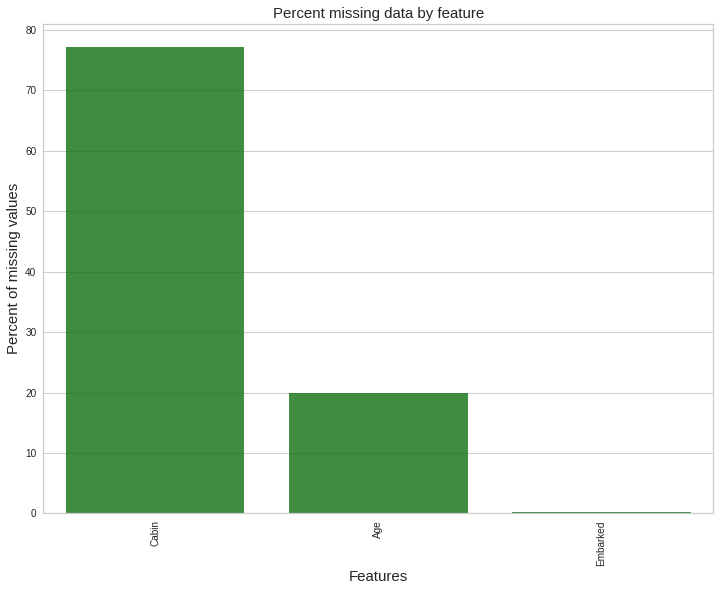

In [ ]:
missingdata(df_train)

In [ ]:
df_train.duplicated().value_counts()

False    891
dtype: int64

In [ ]:
df_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

**Comentário:** Já observamos que a coluna *Age* possui alguns valores missing, devemos escolher como tratar esses dados. (Excluir dados missing? Substituir pela média?). A coluna *Cabin* possui poucos valores preenchidos, provavelmente será descartada da análise. Talvez também poderemos excluir colunas como: *PassengerId*, *Name* e *Ticket* de uma futura modelagem.

**Descrição do que as variáveis representam:** <br>
*Survived*: Indica se o passageiro sobreviveu. (0 = Não, 1 = Sim) <br>
*Pclass*: Classe do passageiro. (1 = Primeira, 2 = Segunda, 3 = Terceira) <br>
*Sex*: Sexo do passageiro. <br>
*Age*: Idade em anos. <br>
*SibSp*: Número de irmãos/cônjuges a bordo do Titanic. <br>
*Parch*: Número de pais/filhos a bordo do Titanic. <br>
*Ticket*: Número do bilhete. <br>
*Fare*: Tarifa de passageiro. <br>
*Cabin*: Número da cabine. <br>
*Embarked*: Porto de embarcação. (C = Cherbourg, Q = Queenstown, S = Southampton)


In [ ]:
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
df_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [ ]:
df_gs.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [ ]:
data_unseen = df_test.merge(df_gs)

In [ ]:
data_unseen.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


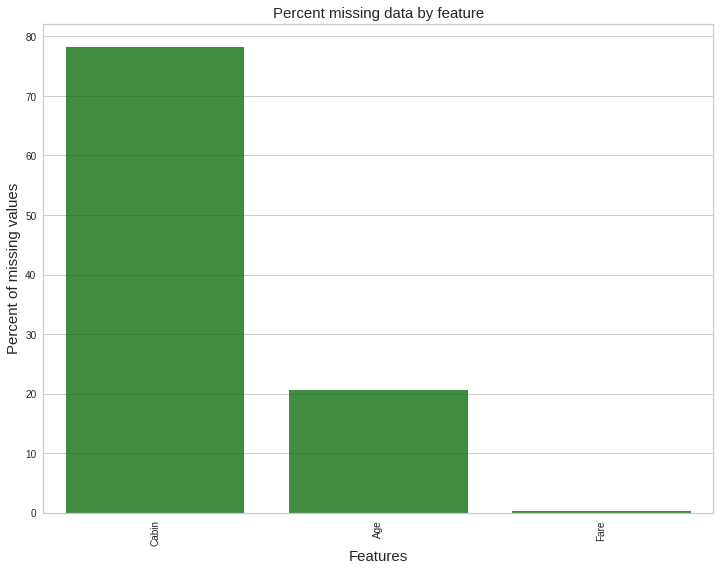

In [ ]:
missingdata(data_unseen)

Vamos tratar esses missings mediana para *Fare* e valor mais comum para *Embarked*:

In [ ]:
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace = True)
data_unseen['Fare'].fillna(data_unseen['Fare'].median(), inplace = True)

# Insights

Irei criar uma coluna que indique o passageiro ter ou não uma Cabine:

In [ ]:
df_train['CabinYN'] = (df_train['Cabin'].notnull()).astype('int')
data_unseen['CabinYN'] = (data_unseen['Cabin'].notnull()).astype('int')

In [ ]:
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinYN
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


Vamos analisar a coluna com nomes:

In [ ]:
df_train.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Interessante, talvez conseguiremos separar os nomes em 5 categorias, *Miss.*, *Mr.*, *Mrs.*, *Master*. Existem algumas outras nomenclaturas que aparecem com muito menos frequência, tomarei a liberdade de nomeá-las como *Other*.

In [ ]:
df_train['Name'].str.extract('(Mr\. |Miss\. |Master\. |Mrs\.)').isna().value_counts()

False    864
True      27
dtype: int64

In [ ]:
df_train['NameInfo'] = df_train['Name'].str.extract('(Mr\.|Miss\.|Master\.|Mrs\.)').fillna('Other.')
df_train['NameInfo'] = df_train['NameInfo'].map(lambda x: str(x)[:-1])
data_unseen['NameInfo'] = data_unseen['Name'].str.extract('(Mr\.|Miss\.|Master\.|Mrs\.)').fillna('Other.')
data_unseen['NameInfo'] = data_unseen['NameInfo'].map(lambda x: str(x)[:-1])

Vamos só comparar essa nova coluna com a coluna *Sex* para vermos a correlação:

In [ ]:
pd.crosstab(df_train['NameInfo'], df_train['Sex'])

Sex,female,male
NameInfo,,
Master,0,40
Miss,182,0
Mr,0,517
Mrs,125,0
Other,7,20


Como esperado meio que subdividimos a coluna *Sex*. Vamos seguir a análise com essa nova coluna.

Para não tratar todos os missings de idade igualmente e gerar 20% dos valores da tabela com o mesmo valor de idade utilizarei as médias de idade das categorias criadas na coluna *NameInfo*:

In [ ]:
AgeMean_train = df_train.groupby(['NameInfo'])['Age'].mean().round(2).to_dict()
AgeMean_train

{'Master': 4.57, 'Miss': 21.77, 'Mr': 32.37, 'Mrs': 35.9, 'Other': 42.38}

In [ ]:
AgeMean_test = data_unseen.groupby(['NameInfo'])['Age'].mean().round(2).to_dict()
AgeMean_test

{'Master': 7.41, 'Miss': 21.77, 'Mr': 32.0, 'Mrs': 38.9, 'Other': 43.83}

In [ ]:
df_train.loc[np.isnan(df_train["Age"]), 'Age'] = df_train['NameInfo'].map(AgeMean_train)
data_unseen.loc[np.isnan(data_unseen["Age"]), 'Age'] = data_unseen['NameInfo'].map(AgeMean_test)

Procurar algum padrão na coluna Ticket:

In [ ]:
df_train.Ticket.head(50)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
20              239865
21              248698
22              330923
23              113788
24              349909
25              347077
26                2631
27               19950
28              330959
29              349216
30            PC 17601
31            PC 17569
32              335677
33          C.A. 24579
34            PC 17604
35              113789
36                2677
37          A./5. 2152
38              345764
39                2651
40                7546
41               11668
42              349253
43       SC

Vendo por cima não parece haver alguma correlação na coluna de Tickets.

Criar uma coluna para o tamanho da família, agrupando *SibSp* e *Parch*.

In [ ]:
df_train["Fsize"] = df_train["SibSp"] + df_train["Parch"] + 1
data_unseen["Fsize"] = data_unseen["SibSp"] + data_unseen["Parch"] + 1

# Descritiva Básica Univariada:

(0.0, 1.0, 0.0, 1.0)

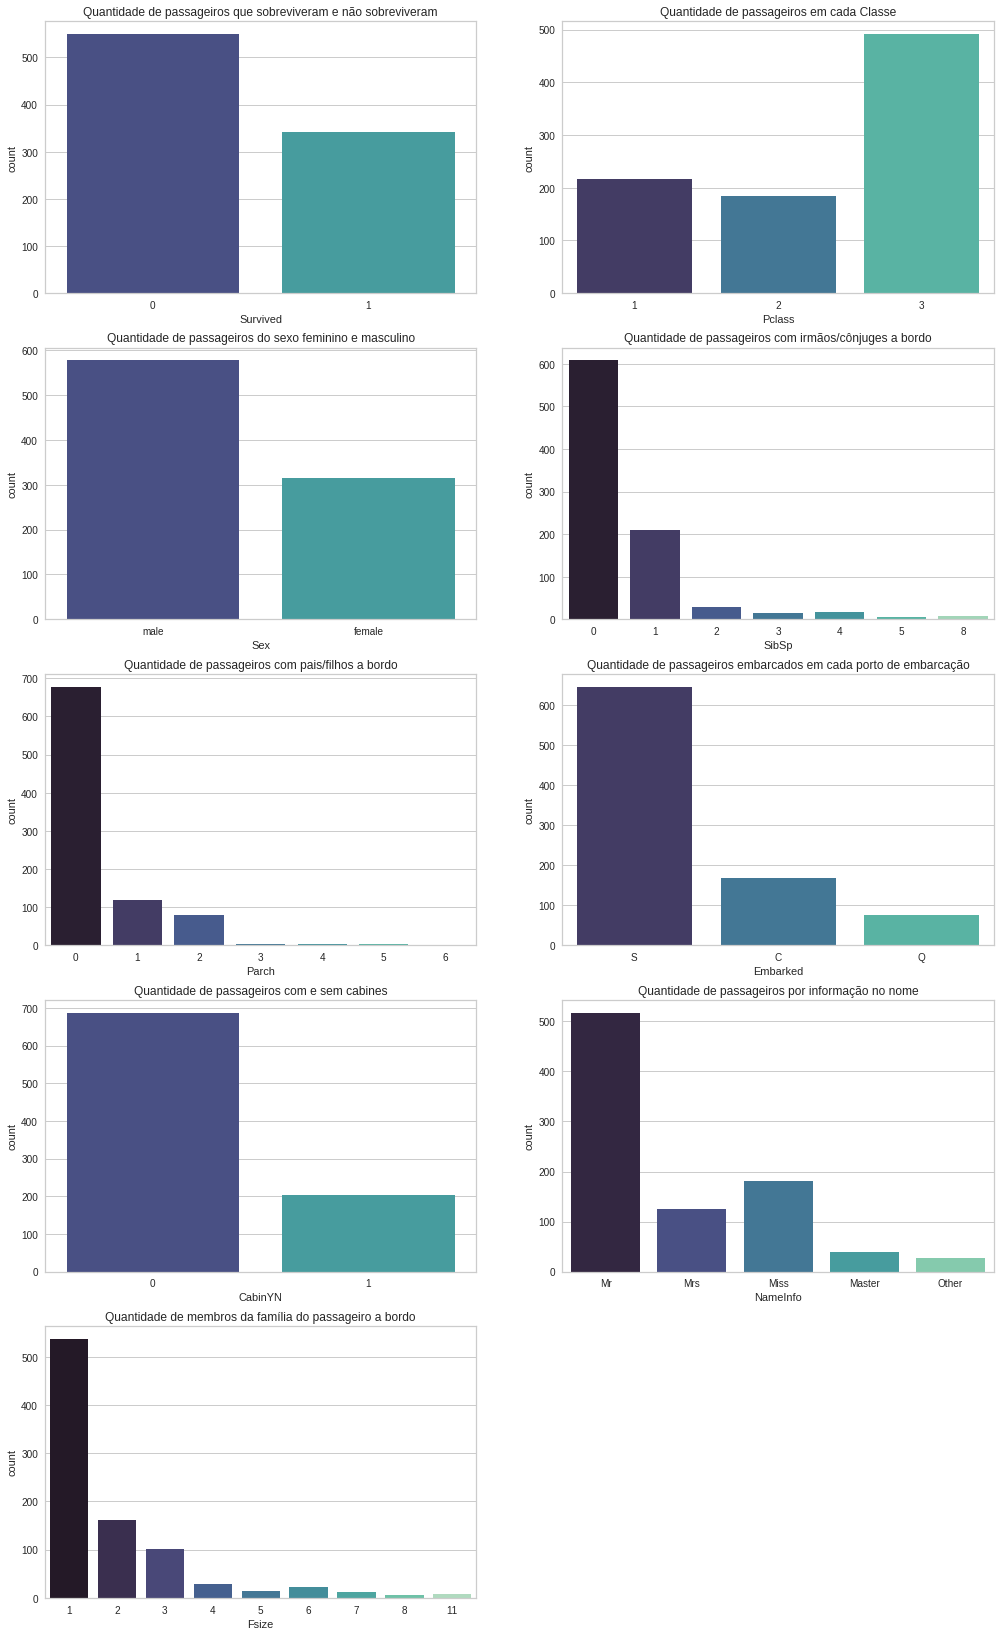

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(17,29))

sns.countplot(data=df_train, x='Survived', palette='mako', ax=ax[0,0])
ax[0,0].set_title('Quantidade de passageiros que sobreviveram e não sobreviveram')

sns.countplot(data=df_train, x='Pclass', palette='mako', ax=ax[0,1])
ax[0,1].set_title('Quantidade de passageiros em cada Classe')

sns.countplot(data=df_train, x='Sex', palette='mako', ax=ax[1,0])
ax[1,0].set_title('Quantidade de passageiros do sexo feminino e masculino')

sns.countplot(data=df_train, x='SibSp', palette='mako', ax=ax[1,1])
ax[1,1].set_title('Quantidade de passageiros com irmãos/cônjuges a bordo')

sns.countplot(data=df_train, x='Parch', palette='mako', ax=ax[2,0])
ax[2,0].set_title('Quantidade de passageiros com pais/filhos a bordo')

sns.countplot(data=df_train, x='Embarked', palette='mako', ax=ax[2,1])
ax[2,1].set_title('Quantidade de passageiros embarcados em cada porto de embarcação')

sns.countplot(data=df_train, x='CabinYN', palette='mako', ax=ax[3,0])
ax[3,0].set_title('Quantidade de passageiros com e sem cabines')

sns.countplot(data=df_train, x='NameInfo', palette='mako', ax=ax[3,1])
ax[3,1].set_title('Quantidade de passageiros por informação no nome')

sns.countplot(data=df_train, x='Fsize', palette='mako', ax=ax[4,0])
ax[4,0].set_title('Quantidade de membros da família do passageiro a bordo')

ax[4,1].axis('off')

**Comentário:** Já obtemos algumas informações, a maioria dos passageiros não sobreviveu, passageiros da terceira classe eram maioria, muito mais homens do que mulheres a bordo, a grande maioria dos passageiros não possuiam irmãos/cônjuges a bordo e/ou pais/filhos a bordo, a maioria dos passageiros embarcaram no porto de Southampton e não possuiam cabines.

Text(0.5, 1.0, 'Quantidade de passageiros por valor da passagem menores que 50')

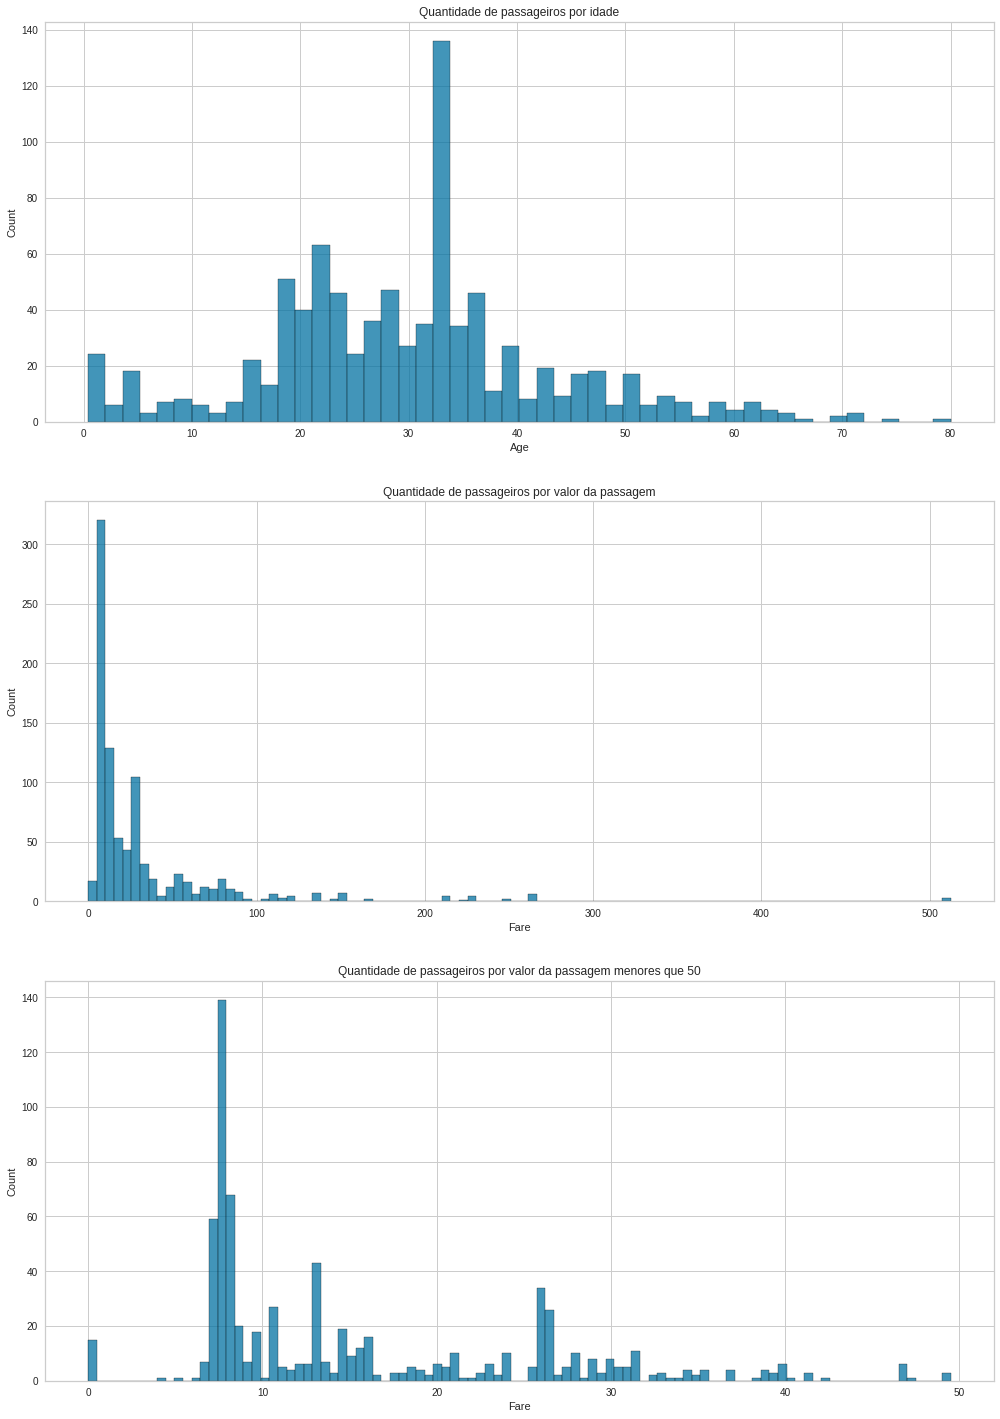

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(17,25))

sns.histplot(data=df_train, x='Age', palette='mako', bins=50, ax=ax[0])
ax[0].set_title('Quantidade de passageiros por idade')

sns.histplot(data=df_train, x='Fare', palette='dark', bins=100, ax=ax[1])
ax[1].set_title('Quantidade de passageiros por valor da passagem')

sns.histplot(data=df_train[df_train.Fare<50], x='Fare', palette='dark', bins=100, ax=ax[2])
ax[2].set_title('Quantidade de passageiros por valor da passagem menores que 50')

**Comentário:** Maior densidade de passageiros entre 15 a 40 anos e a grande maioria das passagens estão na faixa de valor abaixo de 10. 

# Descritiva Bivariada:

Text(0.5, 1.0, 'Quantidade de membros da família do passageiro a bordo')

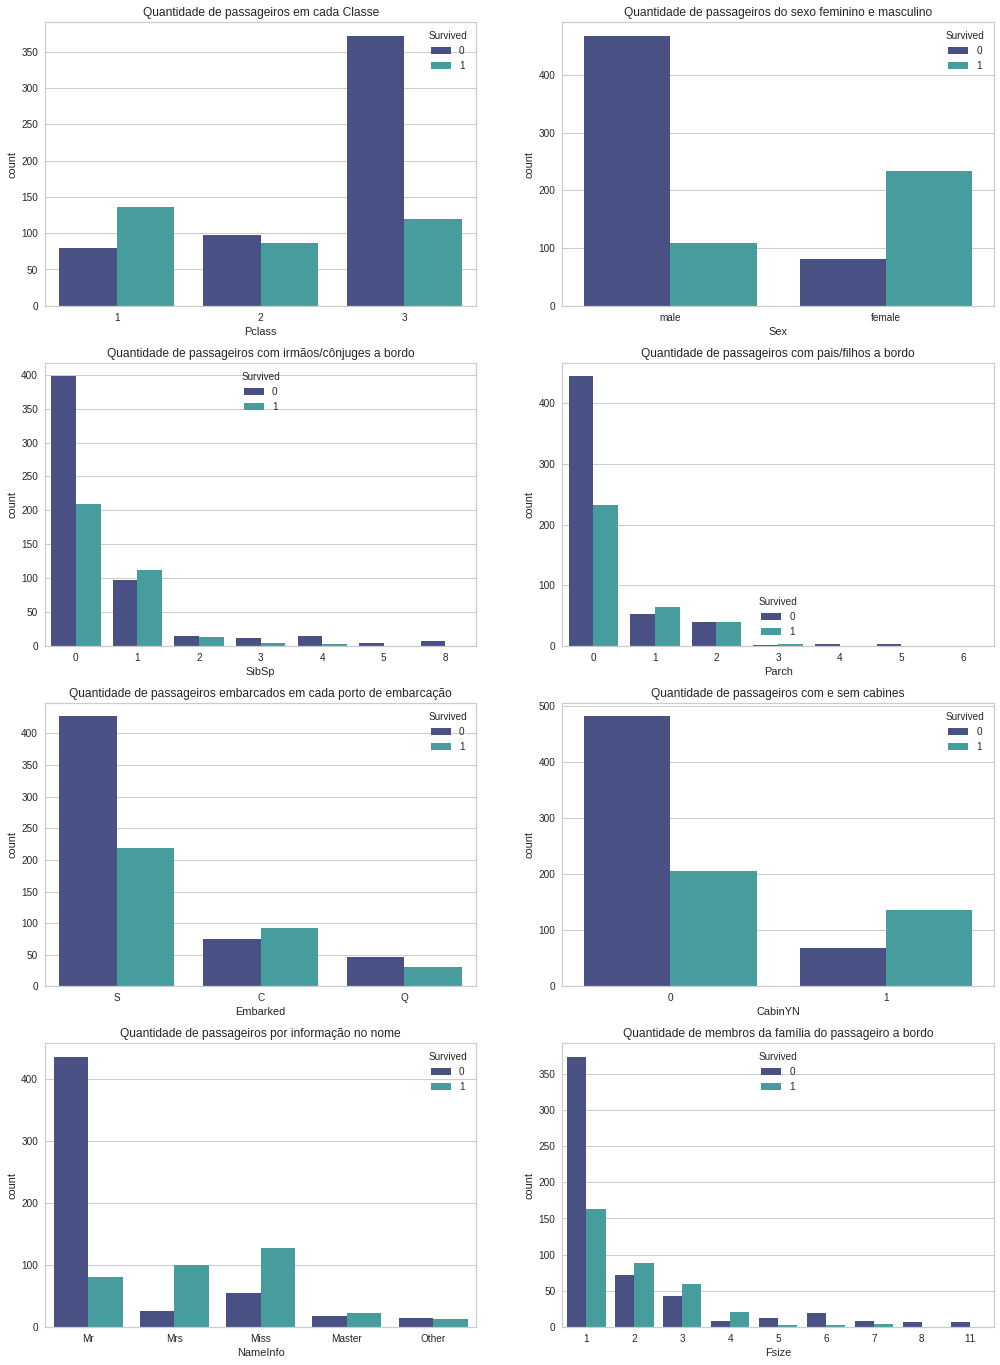

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17,24))

sns.countplot(data=df_train, x='Pclass', palette='mako', hue='Survived', ax=ax[0,0])
ax[0,0].set_title('Quantidade de passageiros em cada Classe')

sns.countplot(data=df_train, x='Sex', palette='mako', hue='Survived', ax=ax[0,1])
ax[0,1].set_title('Quantidade de passageiros do sexo feminino e masculino')

sns.countplot(data=df_train, x='SibSp', palette='mako', hue='Survived', ax=ax[1,0])
ax[1,0].set_title('Quantidade de passageiros com irmãos/cônjuges a bordo')

sns.countplot(data=df_train, x='Parch', palette='mako', hue='Survived', ax=ax[1,1])
ax[1,1].set_title('Quantidade de passageiros com pais/filhos a bordo')

sns.countplot(data=df_train, x='Embarked', palette='mako', hue='Survived', ax=ax[2,0])
ax[2,0].set_title('Quantidade de passageiros embarcados em cada porto de embarcação')

sns.countplot(data=df_train, x='CabinYN', palette='mako', hue='Survived', ax=ax[2,1])
ax[2,1].set_title('Quantidade de passageiros com e sem cabines')

sns.countplot(data=df_train, x='NameInfo', palette='mako', hue='Survived', ax=ax[3,0])
ax[3,0].set_title('Quantidade de passageiros por informação no nome')

sns.countplot(data=df_train, x='Fsize', palette='mako', hue='Survived', ax=ax[3,1])
ax[3,1].set_title('Quantidade de membros da família do passageiro a bordo')

Text(0, 0.5, 'Proporção de sobreviventes')

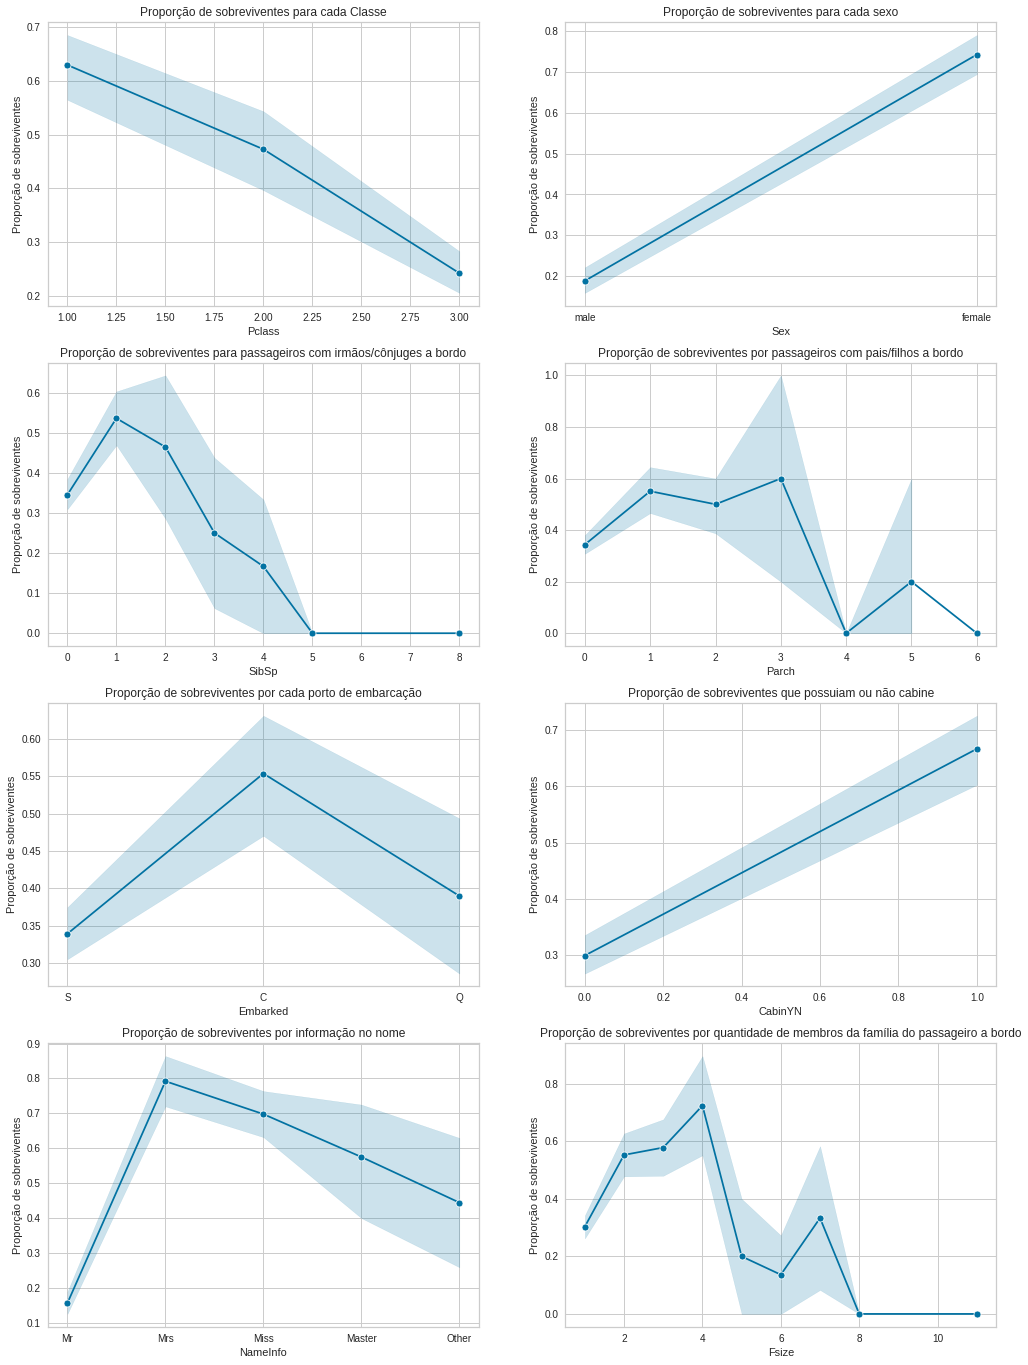

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(17,24))

sns.lineplot(data=df_train, x='Pclass', y='Survived', palette='mako', ax=ax[0,0], marker='o')
ax[0,0].set_title('Proporção de sobreviventes para cada Classe')
ax[0,0].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='Sex', y='Survived', palette='mako', ax=ax[0,1], marker='o')
ax[0,1].set_title('Proporção de sobreviventes para cada sexo')
ax[0,1].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='SibSp', y='Survived', palette='mako', ax=ax[1,0], marker='o')
ax[1,0].set_title('Proporção de sobreviventes para passageiros com irmãos/cônjuges a bordo')
ax[1,0].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='Parch', y='Survived', palette='mako', ax=ax[1,1], marker='o')
ax[1,1].set_title('Proporção de sobreviventes por passageiros com pais/filhos a bordo')
ax[1,1].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='Embarked', y='Survived', palette='mako', ax=ax[2,0], marker='o')
ax[2,0].set_title('Proporção de sobreviventes por cada porto de embarcação')
ax[2,0].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='CabinYN', y='Survived', palette='mako', ax=ax[2,1], marker='o')
ax[2,1].set_title('Proporção de sobreviventes que possuiam ou não cabine')
ax[2,1].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='NameInfo', y='Survived', palette='mako', ax=ax[3,0], marker='o')
ax[3,0].set_title('Proporção de sobreviventes por informação no nome')
ax[3,0].set_ylabel("Proporção de sobreviventes")

sns.lineplot(data=df_train, x='Fsize', y='Survived', palette='mako', ax=ax[3,1], marker='o')
ax[3,1].set_title('Proporção de sobreviventes por quantidade de membros da família do passageiro a bordo')
ax[3,1].set_ylabel("Proporção de sobreviventes")

**Comentário:** *Pclass*, *Sex*, *NameInfo* e *CabinYN* são variáveis que parecem ter valor estatístico para indentificar diferentes entre sobreviventes e não sobreviventes, as demais não parecem apresentar uma tendência a informar mais precisamente sobre sobreviventes.

Text(0.5, 1.0, 'Proporção de sobreviventes para intervalos de idade')

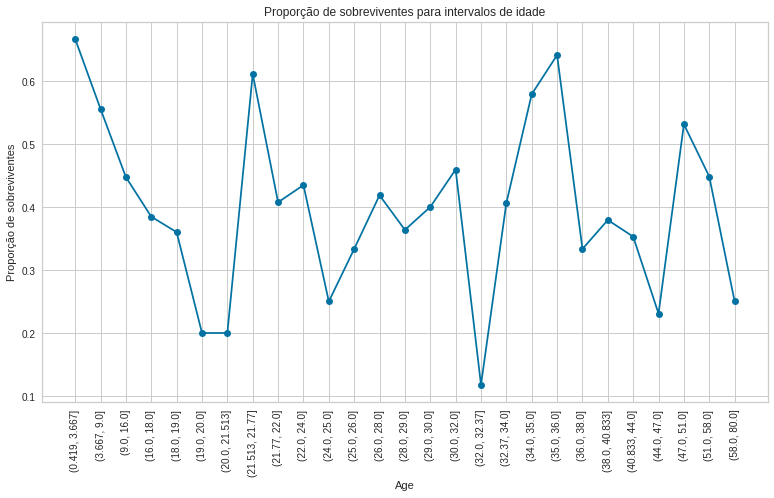

In [ ]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['Age'], 30, duplicates='drop', retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['Survived'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de sobreviventes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de sobreviventes para intervalos de idade')

**Comentário:** A variável *Age* não parece fornecer uma correlação boa com a variável *Survived*.

Text(0.5, 1.0, 'Proporção de sobreviventes para intervalos de valor da passagem')

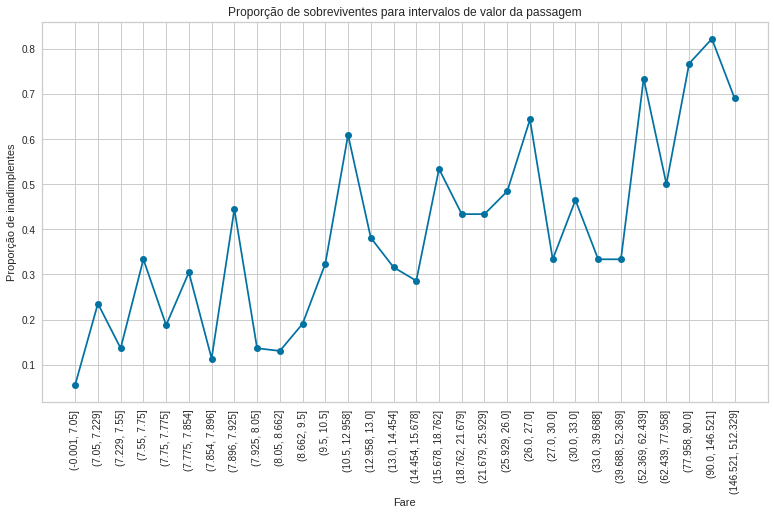

In [ ]:
fig, ax = plt.subplots(figsize=(13,7))

cat_1, bins = pd.qcut(df_train['Fare'], 30, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['Survived'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
ax.set_title('Proporção de sobreviventes para intervalos de valor da passagem')

**Comentário:** A variável *Fare* não parece fornecer uma correlação boa com a variável *Survived*.

Vamos dar uma olhada geral na correlação das nossas colunas:

In [ ]:
corr = df_train.corr() 

<AxesSubplot: >

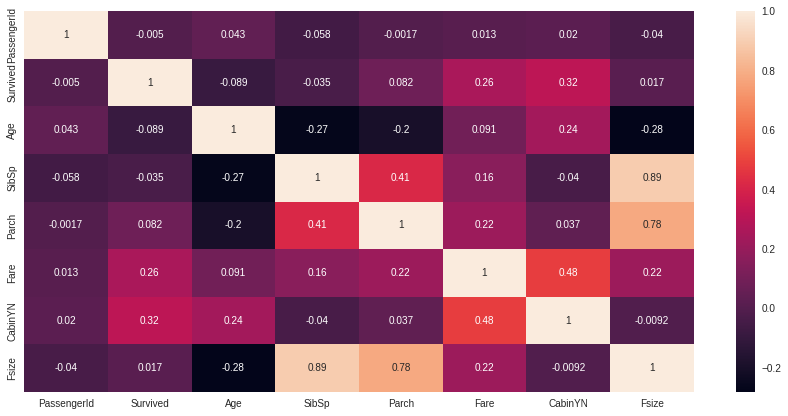

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(corr,annot=True)

# Desenvolvimento do Modelo

Retirando colunas do Dataframe que não são interessantes para uma modelagem:

In [ ]:
data = df_train.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [ ]:
data.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinYN,NameInfo,Fsize
0,0,3,male,22.0,1,0,7.2500,S,0,Mr,2
1,1,1,female,38.0,1,0,71.2833,C,1,Mrs,2


Preparação do Ambiente para o Pycaret:

In [ ]:
%%time

exp_clf = setup(data=data, 
                target = 'Survived', 
                session_id=123, 
                numeric_imputation = True,
                categorical_imputation = 'mode',
                fix_imbalance = True,
                remove_outliers = True,
                outliers_threshold = 0.02) 

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(1020, 19)"
5,Transformed train set shape,"(752, 19)"
6,Transformed test set shape,"(268, 19)"
7,Ordinal features,1
8,Numeric features,6
9,Categorical features,4


CPU times: user 1.49 s, sys: 20.7 ms, total: 1.51 s
Wall time: 1.51 s


Comparação rápida entre os modelos para decidirmos qual vamos utilizar:

In [ ]:
%%time

best_model = compare_models(fold=5, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8347,0.8616,0.7535,0.8043,0.7764,0.6458,0.6483,0.3900
lr,Logistic Regression,0.8266,0.8666,0.7951,0.7642,0.7785,0.6363,0.6376,1.3400
ridge,Ridge Classifier,0.8234,0.0000,0.7700,0.7708,0.7697,0.6266,0.6274,0.2180
lda,Linear Discriminant Analysis,0.8234,0.8653,0.7742,0.7688,0.7706,0.6272,0.6281,0.2480
lightgbm,Light Gradient Boosting Machine,0.8139,0.8534,0.7409,0.7677,0.7511,0.6030,0.6059,0.5200
rf,Random Forest Classifier,0.8122,0.8652,0.7366,0.7690,0.7505,0.6002,0.6024,0.5620
ada,Ada Boost Classifier,0.8122,0.8514,0.7659,0.7503,0.7576,0.6044,0.6049,0.5380
et,Extra Trees Classifier,0.8010,0.8554,0.7449,0.7397,0.7411,0.5797,0.5808,0.4900
nb,Naive Bayes,0.7897,0.8468,0.7909,0.6995,0.7416,0.5654,0.5696,0.2580
dt,Decision Tree Classifier,0.7593,0.7450,0.7113,0.6781,0.6938,0.4957,0.4966,0.2360


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: user 6.99 s, sys: 251 ms, total: 7.24 s
Wall time: 37.6 s


In [ ]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Vamos então criar um modelo utilizando o método Gradient Boosting Classifier:

In [ ]:
%%time

model = create_model('gbc', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8560,0.8609,0.7917,0.8261,0.8085,0.6932,0.6936
1,0.8160,0.8847,0.6667,0.8205,0.7356,0.5968,0.6044
2,0.8160,0.8245,0.7083,0.7907,0.7473,0.6033,0.6055
3,0.8548,0.8624,0.8511,0.7843,0.8163,0.6967,0.6982
4,0.8306,0.8755,0.7500,0.8000,0.7742,0.6389,0.6398
Mean,0.8347,0.8616,0.7535,0.8043,0.7764,0.6458,0.6483
Std,0.0177,0.0205,0.0641,0.0164,0.0321,0.0426,0.0409


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 682 ms, sys: 6.22 ms, total: 688 ms
Wall time: 1.82 s


Melhorar o modelo:

In [ ]:
%%time

tuned_model = tune_model(model, fold=8)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8590,0.9063,0.8333,0.8065,0.8197,0.7039,0.7042
1,0.8205,0.8156,0.7667,0.7667,0.7667,0.6208,0.6208
2,0.8462,0.8712,0.6667,0.9091,0.7692,0.6579,0.6757
3,0.7564,0.7688,0.5667,0.7391,0.6415,0.4619,0.4712
4,0.8590,0.8747,0.8000,0.8276,0.8136,0.7002,0.7005
5,0.8333,0.8326,0.8000,0.7742,0.7869,0.6501,0.6503
6,0.8333,0.8344,0.7333,0.8148,0.7719,0.6412,0.6434
7,0.8312,0.8951,0.8276,0.7500,0.7869,0.6477,0.6498
Mean,0.8299,0.8498,0.7493,0.7985,0.7695,0.6355,0.6395


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 8 folds for each of 10 candidates, totalling 80 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
CPU times: user 2.64 s, sys: 73.9 ms, total: 2.71 s
Wall time: 26.6 s


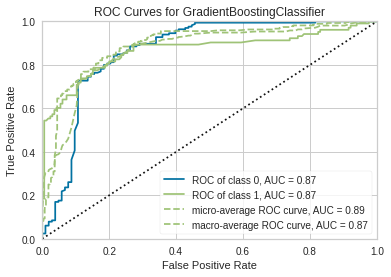

In [ ]:
plot_model(tuned_model, plot = 'auc')

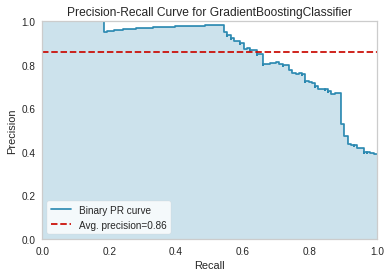

In [ ]:
plot_model(tuned_model, plot = 'pr')

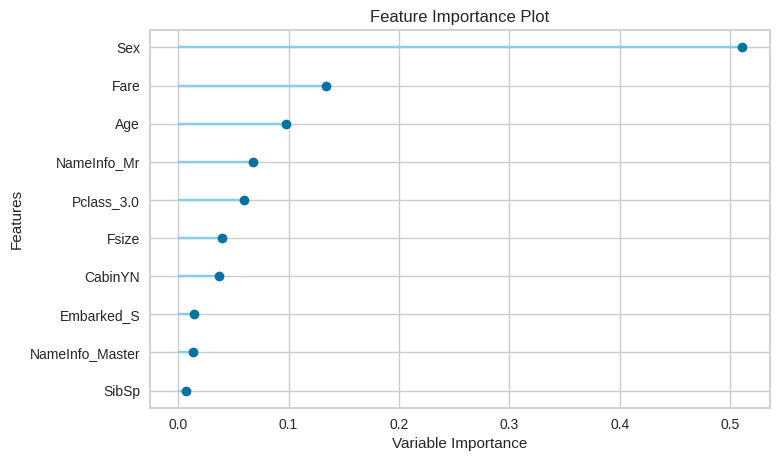

In [ ]:
plot_model(tuned_model, plot = 'feature')

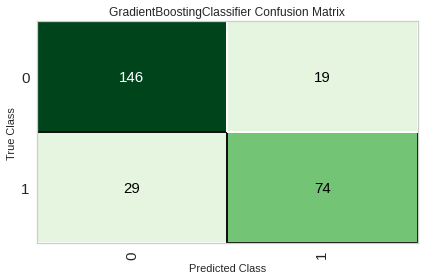

In [ ]:
plot_model(tuned_model, plot = 'confusion_matrix')

Nos gráficos e na matrix de confusão concluímos que o modelo está relativamente conseguindo prever bem a variável resposta, AUC e precisão elevadas, temos que a variável que mais influenciou o modelo foi *Sex*, o que nos faz concluir que as mulheres realmente sobreviveram em maior porcentagem que os homens.

In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
print(final_model)

Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Age', 'SibSp', 'Parch', 'Fare',
                                             'CabinYN', 'Fsize'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=True,
                                                              missing_values=nan,
                                                              strategy='constant',
                                                              verbose=0))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=[...
                                            criterion='friedman_mse', init=None,
                          

Teste com dados não utilizados no modelo:

In [ ]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8756,0.9365,0.8421,0.8205,0.8312,0.7327,0.7329


,Pclass_2.0,Pclass_3.0,Pclass_1.0,Sex,Age,SibSp,Parch,Fare,Embarked_S,Embarked_Q,...,CabinYN,NameInfo_Miss,NameInfo_Mr,NameInfo_Mrs,NameInfo_Master,NameInfo_Other,Fsize,Survived,prediction_label,prediction_score
0,0.0,1.0,0.0,1.0,34.5,0.0,0.0,7.8292,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.8894
1,0.0,1.0,0.0,0.0,47.0,1.0,0.0,7.0000,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1,0,0.8622
2,1.0,0.0,0.0,1.0,62.0,0.0,0.0,9.6875,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.9108
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,8.6625,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.6926
4,0.0,1.0,0.0,0.0,22.0,1.0,1.0,12.2875,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1,1,0.5831


E aqui concluimos que até na base de testes fornecida conseguimos umas acurácia de 0.8756 e um AUC de 0.9365, números grandes em uma modelagem de dados.